<center><h1>In the name of Allah</h1></center>

Name: Payam Taebi

Student Number:400104867

In this notebook, you will explore adversarial attacks and training methods in deep learning. First, you will train a simple model, ResNet18, on the CIFAR-10 dataset. Next, you will learn about two different adversarial attacks: FGSM (Fast Gradient Sign Method) and PGD (Projected Gradient Descent). To enhance your understanding, you will implement the PGD attack from scratch, while the FGSM attack will be implemented using a library. After this, you will use the FGSM attack to generate adversarial examples and then perform adversarial training on the model using the CIFAR-10 dataset. Finally, you will compare the performance and robustness of the adversarially trained model with the original model. 

Good luck!

## outline
- Train Resnet on CIFAR10
- FGSM Attack using torchattacks
- PGD Attack from scratch
- Visualization
- Adversarial Training


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Train Resnet on CIFAR10 (15 pts)

In [3]:
# Define transformations for the training and test sets
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Load the CIFAR-10 training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Define the classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:11<00:00, 15196424.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Model architecture
class ResNet(nn.Module):
    def __init__(self, num_cls):
        super().__init__()
        self.conv = nn.Sequential(*list(resnet18(weights=None).children())[:-2])
        self.fc = nn.Linear(512, num_cls)

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        logits = self.fc(x)
        return logits

# Initialize model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(num_cls=len(classes)).to(device)

################################ End #########################################


In [5]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100

In [6]:
##############################################################################
# Implement train loop and log training loss after each epoch                #
##############################################################################

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Log training loss
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss}')

################################ End #########################################


Epoch [1/100], Loss: 1.6923587840536367
Epoch [2/100], Loss: 1.376214591133625
Epoch [3/100], Loss: 1.211514735923094
Epoch [4/100], Loss: 1.077691117211071
Epoch [5/100], Loss: 0.9975619235307055
Epoch [6/100], Loss: 0.9354312744591852
Epoch [7/100], Loss: 0.8748786184184082
Epoch [8/100], Loss: 0.833215408313
Epoch [9/100], Loss: 0.7981095129571607
Epoch [10/100], Loss: 0.759027043038317
Epoch [11/100], Loss: 0.7342009570287622
Epoch [12/100], Loss: 0.6994054531654739
Epoch [13/100], Loss: 0.6797038594932507
Epoch [14/100], Loss: 0.6548321526831068
Epoch [15/100], Loss: 0.6398864084344995
Epoch [16/100], Loss: 0.6178103878979793
Epoch [17/100], Loss: 0.5974436906902382
Epoch [18/100], Loss: 0.5815166817296802
Epoch [19/100], Loss: 0.5669110793134441
Epoch [20/100], Loss: 0.5494899668199632
Epoch [21/100], Loss: 0.5388378795150601
Epoch [22/100], Loss: 0.5229555460650598
Epoch [23/100], Loss: 0.5112311353006631
Epoch [24/100], Loss: 0.49804732477878366
Epoch [25/100], Loss: 0.48472827

In [7]:
##############################################################################
# Evaluate the trained model on test set and print test accuracy             #
##############################################################################

model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Train Accuracy of the model : {accuracy:.2f}%')

################################ End #########################################


Train Accuracy of the model : 95.64%


In [8]:
##############################################################################
# Evaluate the trained model on test set and print test accuracy             #
##############################################################################

model.eval() 
correct = 0
total = 0

with torch.no_grad():  # No need
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy of the model: {accuracy:.2f}%')

################################ End #########################################


Test Accuracy of the model: 81.52%


In [9]:
# Save model
model.eval()
model_name = "resnet18_cifar10_model_pretrained.pth"
model_PATH = f"{model_name}"
torch.save(model.state_dict(), model_PATH)

## FGSM Attack using torchattacks (10 pts)

In this section you should run FGSM attack using torchattacks library (https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html).

Run the attack for $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on untargeted FGSM attack on the test data.

In [10]:
!pip install torchattacks
import torchattacks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.9.0 requires keras-core, which is not installed.
keras-nlp 0.12.1 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-b

In [11]:
def evaluate_adversarial(model, testloader, attack):
    model.eval()
    correct = 0
    total = 0
    
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        adv_inputs = attack(inputs, labels)
        outputs = model(adv_inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy


In [12]:
##############################################################################
# run untargeted FGSM attack for epsilon = 1/255 and report its accuracy     #
##############################################################################


epsilon = 1/255
attack = torchattacks.FGSM(model, eps=epsilon)
accuracy = evaluate_adversarial(model, testloader, attack)
print(f'FGSM Attack with epsilon={epsilon}: Test Accuracy = {accuracy}%')




################################ End #########################################

FGSM Attack with epsilon=0.00392156862745098: Test Accuracy = 60.01%


In [13]:
##############################################################################
# run untargeted FGSM attack for epsilon = 4/255 and report its accuracy     #
##############################################################################


# FGSM Attack with epsilon=4/255
epsilon = 4/255
attack = torchattacks.FGSM(model, eps=epsilon)
accuracy = evaluate_adversarial(model, testloader, attack)
print(f'FGSM Attack with epsilon={epsilon}: Test Accuracy = {accuracy}%')





################################ End #########################################

FGSM Attack with epsilon=0.01568627450980392: Test Accuracy = 21.33%


In [14]:
##############################################################################
# run untargeted FGSM attack for epsilon = 8/255 and report its accuracy     #
##############################################################################


# FGSM Attack with epsilon=4/255
epsilon = 8/255
attack = torchattacks.FGSM(model, eps=epsilon)
accuracy = evaluate_adversarial(model, testloader, attack)
print(f'FGSM Attack with epsilon={epsilon}: Test Accuracy = {accuracy}%')





################################ End #########################################

FGSM Attack with epsilon=0.03137254901960784: Test Accuracy = 11.16%


## PGD Attack from scratch (30 pts)

In this section you should implement PGD attack from scratch.

In [15]:
class LinfPGDAttack:
    def __init__(self, model, epsilon=8/255, num_steps=2, step_size=2/255):
        self.model = model
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.step_size = step_size

    def perturb(self, images, labels):
        images = images.to(device)
        labels = labels.to(device)

        adv_images = images.clone().detach().to(device)
        adv_images.requires_grad = True

        for _ in range(self.num_steps):
            outputs = self.model(adv_images)
            loss = F.cross_entropy(outputs, labels)

            self.model.zero_grad()
            loss.backward()

            with torch.no_grad():
                adv_images += self.step_size * adv_images.grad.sign()
                adv_images = torch.clamp(adv_images, min=images - self.epsilon, max=images + self.epsilon)
                adv_images = torch.clamp(adv_images, 0, 1)

            adv_images = adv_images.detach()
            adv_images.requires_grad = True

        return adv_images

    def __call__(self, images, labels):
        return self.perturb(images, labels)


In [16]:
def evaluate_pgd_adversarial(model, testloader, attack):
    model.eval()
    correct = 0
    total = 0
    
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        adv_inputs = attack(inputs, labels)
        outputs = model(adv_inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# PGD Attack evaluation
pgd_attack = LinfPGDAttack(model, epsilon=8/255, num_steps=10, step_size=2/255)
accuracy = evaluate_pgd_adversarial(model, testloader, pgd_attack)
print(f'PGD Attack: Test Accuracy = {accuracy:.2f}%')


PGD Attack: Test Accuracy = 0.35%


In [17]:
##############################################################################
# Evaluate PGD attack on the trained model with k=2,4,8                      #
##############################################################################

k_list = [2, 4, 8]

for k in k_list:
    pgd_attack = LinfPGDAttack(model, epsilon=8/255, num_steps=k, step_size=2/255)
    accuracy = evaluate_pgd_adversarial(model, testloader, pgd_attack)
    print(f'Accuracy of the model on the 10000 test images after PGD attack with k = {k}: {accuracy:.2f} %')

################################ End #########################################


Accuracy of the model on the 10000 test images after PGD attack with k = 2: 15.60 %
Accuracy of the model on the 10000 test images after PGD attack with k = 4: 2.42 %
Accuracy of the model on the 10000 test images after PGD attack with k = 8: 0.46 %


## Visualization (10 pts)

Implement a function to plot the original image, the perturbed imaged and their predicted labels by the model

In [18]:
##############################################################################
# Implement the function described                                           #
##############################################################################

import matplotlib.pyplot as plt
import random

def visualize_attack(model, attack, testloader, attack_name, num_images=3):
    model.eval()
    
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    # Select random images
    indices = random.sample(range(len(images)), num_images)
    selected_images = images[indices]
    selected_labels = labels[indices]
    
    # Get perturbed images
    perturbed_images = attack(selected_images, selected_labels)
    
    # Get model predictions
    original_outputs = model(selected_images)
    perturbed_outputs = model(perturbed_images)
    
    _, original_preds = torch.max(original_outputs, 1)
    _, perturbed_preds = torch.max(perturbed_outputs, 1)
    
    # Plotting
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 10))
    for i in range(num_images):
        # Original Image
        axes[i, 0].imshow(selected_images[i].cpu().permute(1, 2, 0).detach().numpy())
        axes[i, 0].set_title(f'Original: {classes[selected_labels[i]]}\nPredicted: {classes[original_preds[i]]}')
        axes[i, 0].axis('off')
        
        # Perturbed Image
        axes[i, 1].imshow(perturbed_images[i].cpu().permute(1, 2, 0).detach().numpy())
        axes[i, 1].set_title(f'Perturbed: {classes[selected_labels[i]]}\nPredicted: {classes[perturbed_preds[i]]}')
        axes[i, 1].axis('off')
    
    plt.suptitle(f'{attack_name} Attack Visualization', fontsize=16)
    plt.tight_layout()
    plt.show()


################################ End #########################################

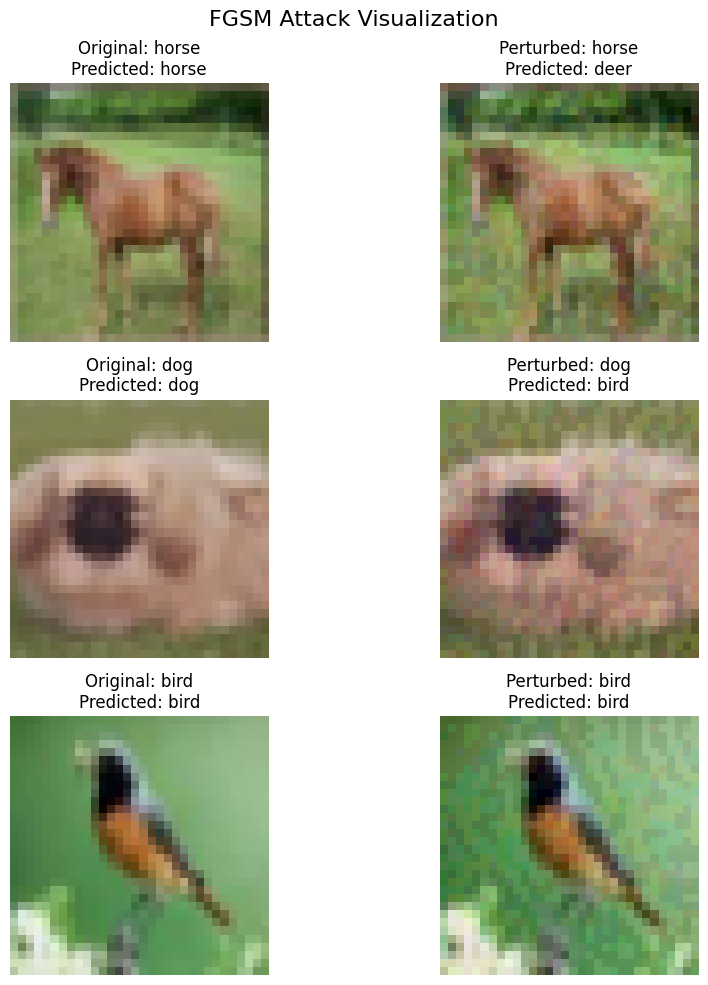

In [19]:
##############################################################################
# Choose 3 random images from testset and run FGSM attack and visualize      #
##############################################################################

fgsm_attack = torchattacks.FGSM(model, eps=8/255)
visualize_attack(model, fgsm_attack, testloader, 'FGSM')


################################ End #########################################

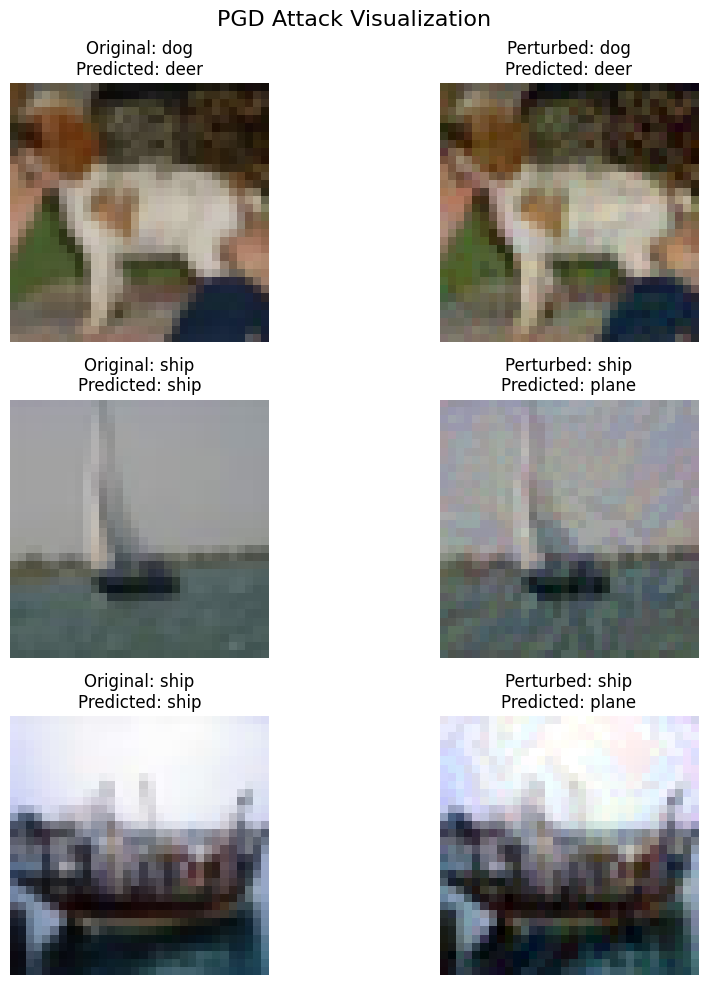

In [20]:
##############################################################################
# Choose 3 random images from testset and run PGD attack and visualize      #
##############################################################################


pgd_attack = LinfPGDAttack(model, epsilon=8/255, num_steps=10, step_size=2/255)
visualize_attack(model, pgd_attack, testloader, 'PGD')


################################ End #########################################

## Adversarial Training (35 pts)

In this section you are going to adversarially train your model and see the results. 

In [21]:
##############################################################################
# Load a new resnet model for adversarial training                           #
# Train the model on perturbed images from                                   #
# untargeted FGSM attack with epsilon = 8/255 on train dataset               #
# Also use the following setup for training the model                        #
##############################################################################

# Load a new ResNet model for adversarial training
adv_model = ResNet(num_cls=len(classes)).to(device)

# Training setup
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adv_model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100

# FGSM attack for generating adversarial examples
fgsm_attack = torchattacks.FGSM(adv_model, eps=8/255)

# Adversarial training loop
for epoch in range(epochs):
    adv_model.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        adv_inputs = fgsm_attack(inputs, labels)
        
        optimizer.zero_grad()
        

        outputs = adv_model(adv_inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Log training loss
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss}')

# Save the adversarially trained model
torch.save(adv_model.state_dict(), 'adv_resnet18.pth')

################################ End #########################################

Epoch [1/100], Loss: 2.2006266428076704
Epoch [2/100], Loss: 2.0916983175765522
Epoch [3/100], Loss: 2.037704934854337
Epoch [4/100], Loss: 2.0048208300719788
Epoch [5/100], Loss: 1.9809621173097653
Epoch [6/100], Loss: 1.9621980492111362
Epoch [7/100], Loss: 1.9416042682155015
Epoch [8/100], Loss: 1.9300936948307945
Epoch [9/100], Loss: 1.9117659132194031
Epoch [10/100], Loss: 1.8986624918325479
Epoch [11/100], Loss: 1.8843587389992327
Epoch [12/100], Loss: 1.870939380982343
Epoch [13/100], Loss: 1.8618182334143791
Epoch [14/100], Loss: 1.8550801896073323
Epoch [15/100], Loss: 1.8434209158963255
Epoch [16/100], Loss: 1.8339038142157942
Epoch [17/100], Loss: 1.8205828904495824
Epoch [18/100], Loss: 1.8156237184544048
Epoch [19/100], Loss: 1.810631226395707
Epoch [20/100], Loss: 1.7980388287083267
Epoch [21/100], Loss: 1.7942011441721026
Epoch [22/100], Loss: 1.7834247643380519
Epoch [23/100], Loss: 1.77478357410187
Epoch [24/100], Loss: 1.7675331562681271
Epoch [25/100], Loss: 1.761695

In [22]:
##############################################################################
# Evaluate the new model on the test dataset                                 #
##############################################################################

model.eval()  
correct = 0
total = 0

with torch.no_grad():  # No need 
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Train Accuracy of the model : {accuracy:.2f}%')



model.eval() 
correct = 0
total = 0

with torch.no_grad():  # No need 
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy of the model: {accuracy:.2f}%')

################################ End #########################################

################################ End #########################################

Train Accuracy of the model : 95.72%
Test Accuracy of the model: 81.52%


In [23]:
##############################################################################
# Run FGSM attack on the adversarially trained model with epsilon = 8/255    #
##############################################################################

# Define the FGSM attack
fgsm_attack = torchattacks.FGSM(adv_model, eps=8/255)

def evaluate_fgsm_adversarial(model, testloader, attack):
    model.eval()
    correct = 0
    total = 0
    
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        adv_inputs = attack(inputs, labels)
        outputs = model(adv_inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Evaluate the adversarially trained model with FGSM attack
fgsm_accuracy = evaluate_fgsm_adversarial(adv_model, testloader, fgsm_attack)
print(f'Test Accuracy of the adversarially trained model under FGSM attack: {fgsm_accuracy:.2f}%')

################################ End #########################################


Test Accuracy of the adversarially trained model under FGSM attack: 36.12%


In [24]:
##############################################################################
#  Run PGD attack on the adversarially trained model with k=4                #
##############################################################################

# Define the PGD attack
pgd_attack = LinfPGDAttack(model=adv_model, epsilon=8/255, num_steps=4, step_size=2/255)

def evaluate_pgd_adversarial(model, testloader, attack):
    model.eval()
    correct = 0
    total = 0
    
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        adv_inputs = attack(inputs, labels)
        outputs = model(adv_inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Evaluate the adversarially trained model with PGD attack
pgd_accuracy = evaluate_pgd_adversarial(adv_model, testloader, pgd_attack)
print(f'Test Accuracy of the adversarially trained model under PGD attack: {pgd_accuracy:.2f}%')

################################ End #########################################


Test Accuracy of the adversarially trained model under PGD attack: 32.96%


Answer the following questions:
- **What happened to the accuracy of the adversarially trained model?**
  The accuracy of the adversarially trained model is significantly high on clean data, with a train accuracy of 95.72% and a test accuracy of 81.52%.

- **What do you conclude from the result of the FGSM attack on the adversarially trained model?**
  The test accuracy under FGSM attack dropped to 36.12%. This indicates that while the adversarial training improved robustness against FGSM attacks compared to a non-adversarially trained model, the model is still vulnerable to this type of attack, showing a significant reduction in accuracy.

- **What do you conclude from the result of the PGD attack on the adversarially trained model?**
  The test accuracy under PGD attack is 32.96%, which is slightly lower than the accuracy under FGSM attack. This suggests that PGD, being a stronger and more iterative attack compared to FGSM, is more effective in reducing the model's performance, even when the model is adversarially trained.

- **What is your final conclusion?**
  Adversarial training enhances the robustness of models against adversarial attacks, but it does not entirely eliminate vulnerability. The adversarially trained model shows a significant drop in accuracy under both FGSM and PGD attacks, with PGD being more effective. This indicates that while adversarial training is beneficial, further improvements and advanced defense mechanisms are needed to enhance robustness against sophisticated adversarial attacks.
